Ben Ghertner 2025

Read CM1 output and generate plots.

    - Figure 3.10

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['text.usetex'] = True
plt.rcParams["font.size"] = 11

%matplotlib inline


In [2]:
#Constants
Rd = 287.04
Rv = 461.5
cpd = 1005.7
cpv = 1870
cpl = 4190.0
g = 9.81

p00 = 1e5

#Latent heat of vapourization function
lv = lambda T: 2501000.0 + (cpl-cpv)*(273.15 - T)

#CM1 r^star(p, T) function
def rslf(p,T,ptype=1):
    if ptype==4:
        return 380.00*np.exp(17.2693882-4097.8531/(T-35.86))/p
    else:
        estar = 611.2 * np.exp( 17.67 * ( T  - 273.15 ) / ( T  - 29.65 ) )
        return Rd/Rv*estar/(p-estar)

In [3]:
#Read CM1 background and wave output files
dsback = xr.open_dataset("./cm1DispersionTest/domain_1000/cm1base.nc")
dsout = xr.open_dataset("./cm1DispersionTest/domain_1000/cm1out.nc")

/var/folders/gn/cfbkg9gx4p35qfks288gj5wr0000gn/T/ipykernel_67348/2576585605.py:2: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  dsback = xr.open_dataset("./cm1DispersionTest/domain_1000/cm1base.nc")
/var/folders/gn/cfbkg9gx4p35qfks288gj5wr0000gn/T/ipykernel_67348/2576585605.py:3: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  dsout = xr.open_dataset("./cm1DispersionTest/domain_1000/cm1out.nc")


In [4]:
#Save values into arrays for background state
pbar = dsback['prs'].values[0,:,0,0]
thbar = dsback['th'].values[0,:,0,0]
rvbar = dsback['qv'].values[0,:,0,0]
rlbar = dsback['ql'].values[0,:,0,0]
rTbar = rvbar + rlbar
pibar = (pbar/p00)**(Rd/cpd)
Tbar = thbar*pibar
rsbar = rslf(pbar,Tbar)

#Computed values
RTbar = Rd + rTbar*Rv
cpTbar = cpd + rTbar*cpv
thrbar = Tbar*(p00/pbar)**(RTbar/cpTbar)*(Rd + rvbar*Rv)/Rd/(1 + rTbar)
thlbar = Tbar*(p00/pbar)**((Rd+rTbar*Rv)/(cpd+rTbar*cpv))*np.exp(-lv(Tbar)/(cpd+rTbar*cpv)/Tbar*rlbar)*((Rd+rvbar*Rv)/(Rd+rTbar*Rv))**((Rd+rTbar*Rv)/(cpd+rTbar*cpv))*(rTbar/rvbar)**(rTbar*Rv/(cpd+rTbar*cpv))

In [5]:
#Save values into arrays for the wave output
xh = dsout['xh'].values
zh = dsout['zh'].values
xf = dsout['xf'].values
zf = dsout['zf'].values

p = dsout['prs'].values[:,:,0,:]
th = dsout['th'].values[:,:,0,:]
rv = dsout['qv'].values[:,:,0,:]
rl = dsout['ql'].values[:,:,0,:]
rT = rv + rl
pi = (p/p00)**(Rd/cpd)
T = th*pi
rs = rslf(p,T)

#Computed values
RT = Rd + rT*Rv
cpT = cpd + rT*cpv
thr = T*(p00/p)**(RT/cpT)*(Rd + rv*Rv)/Rd/(1 + rT)
thl = T*(p00/p)**((Rd+rT*Rv)/(cpd+rT*cpv))*np.exp(-lv(T)/(cpd+rT*cpv)/T*rl)*((Rd+rv*Rv)/(Rd+rT*Rv))**((Rd+rT*Rv)/(cpd+rT*cpv))*(rT/rv)**(rT*Rv/(cpd+rT*cpv))

#Winds
w = dsout['w'].values[:,:,0,:]
u = dsout['u'].values[:,:,0,:]

In [6]:
#Compute the measured edge location 
#Note: I've been a bit sloppy. In my thesis I claimed we
#could do interpolation of the liquid water function
#but we need to compute analytic extensions of the cloudy
#r^star into the clear in order to do this. This code
#just does the simple extrapolation as in Walsh & Muraki (2024).

#time in CM1 is in nanoseconds for some reason - convert to seconds
t = dsout['time'].to_numpy().astype('float')/1.0e9

Nt, Nz, Nx = rl.shape
#initialize array of interface heights in time-space
Zcm1 = np.zeros((Nt,Nx))

#loop through time points
for idt in range(Nt):
    #loop through horizontal space points
    for idx in range(Nx):
        #move up through vertical points until interface is found
        for idz in range(Nz):
            #Stop two shy of 0 water to extrapolate last two positive rl points
            if rl[idt,idz+2,idx] == 0:
                #Linear extrapolation to find 0 rl level
                rl1 = rl[idt,idz,idx]
                rl2 = rl[idt,idz+1,idx]
                m = (rl2 - rl1)/(zh[idz+1] - zh[idz])
                Zcm1[idt,idx] = zh[idz] - rl1/m
                break

**Figure 3.10**

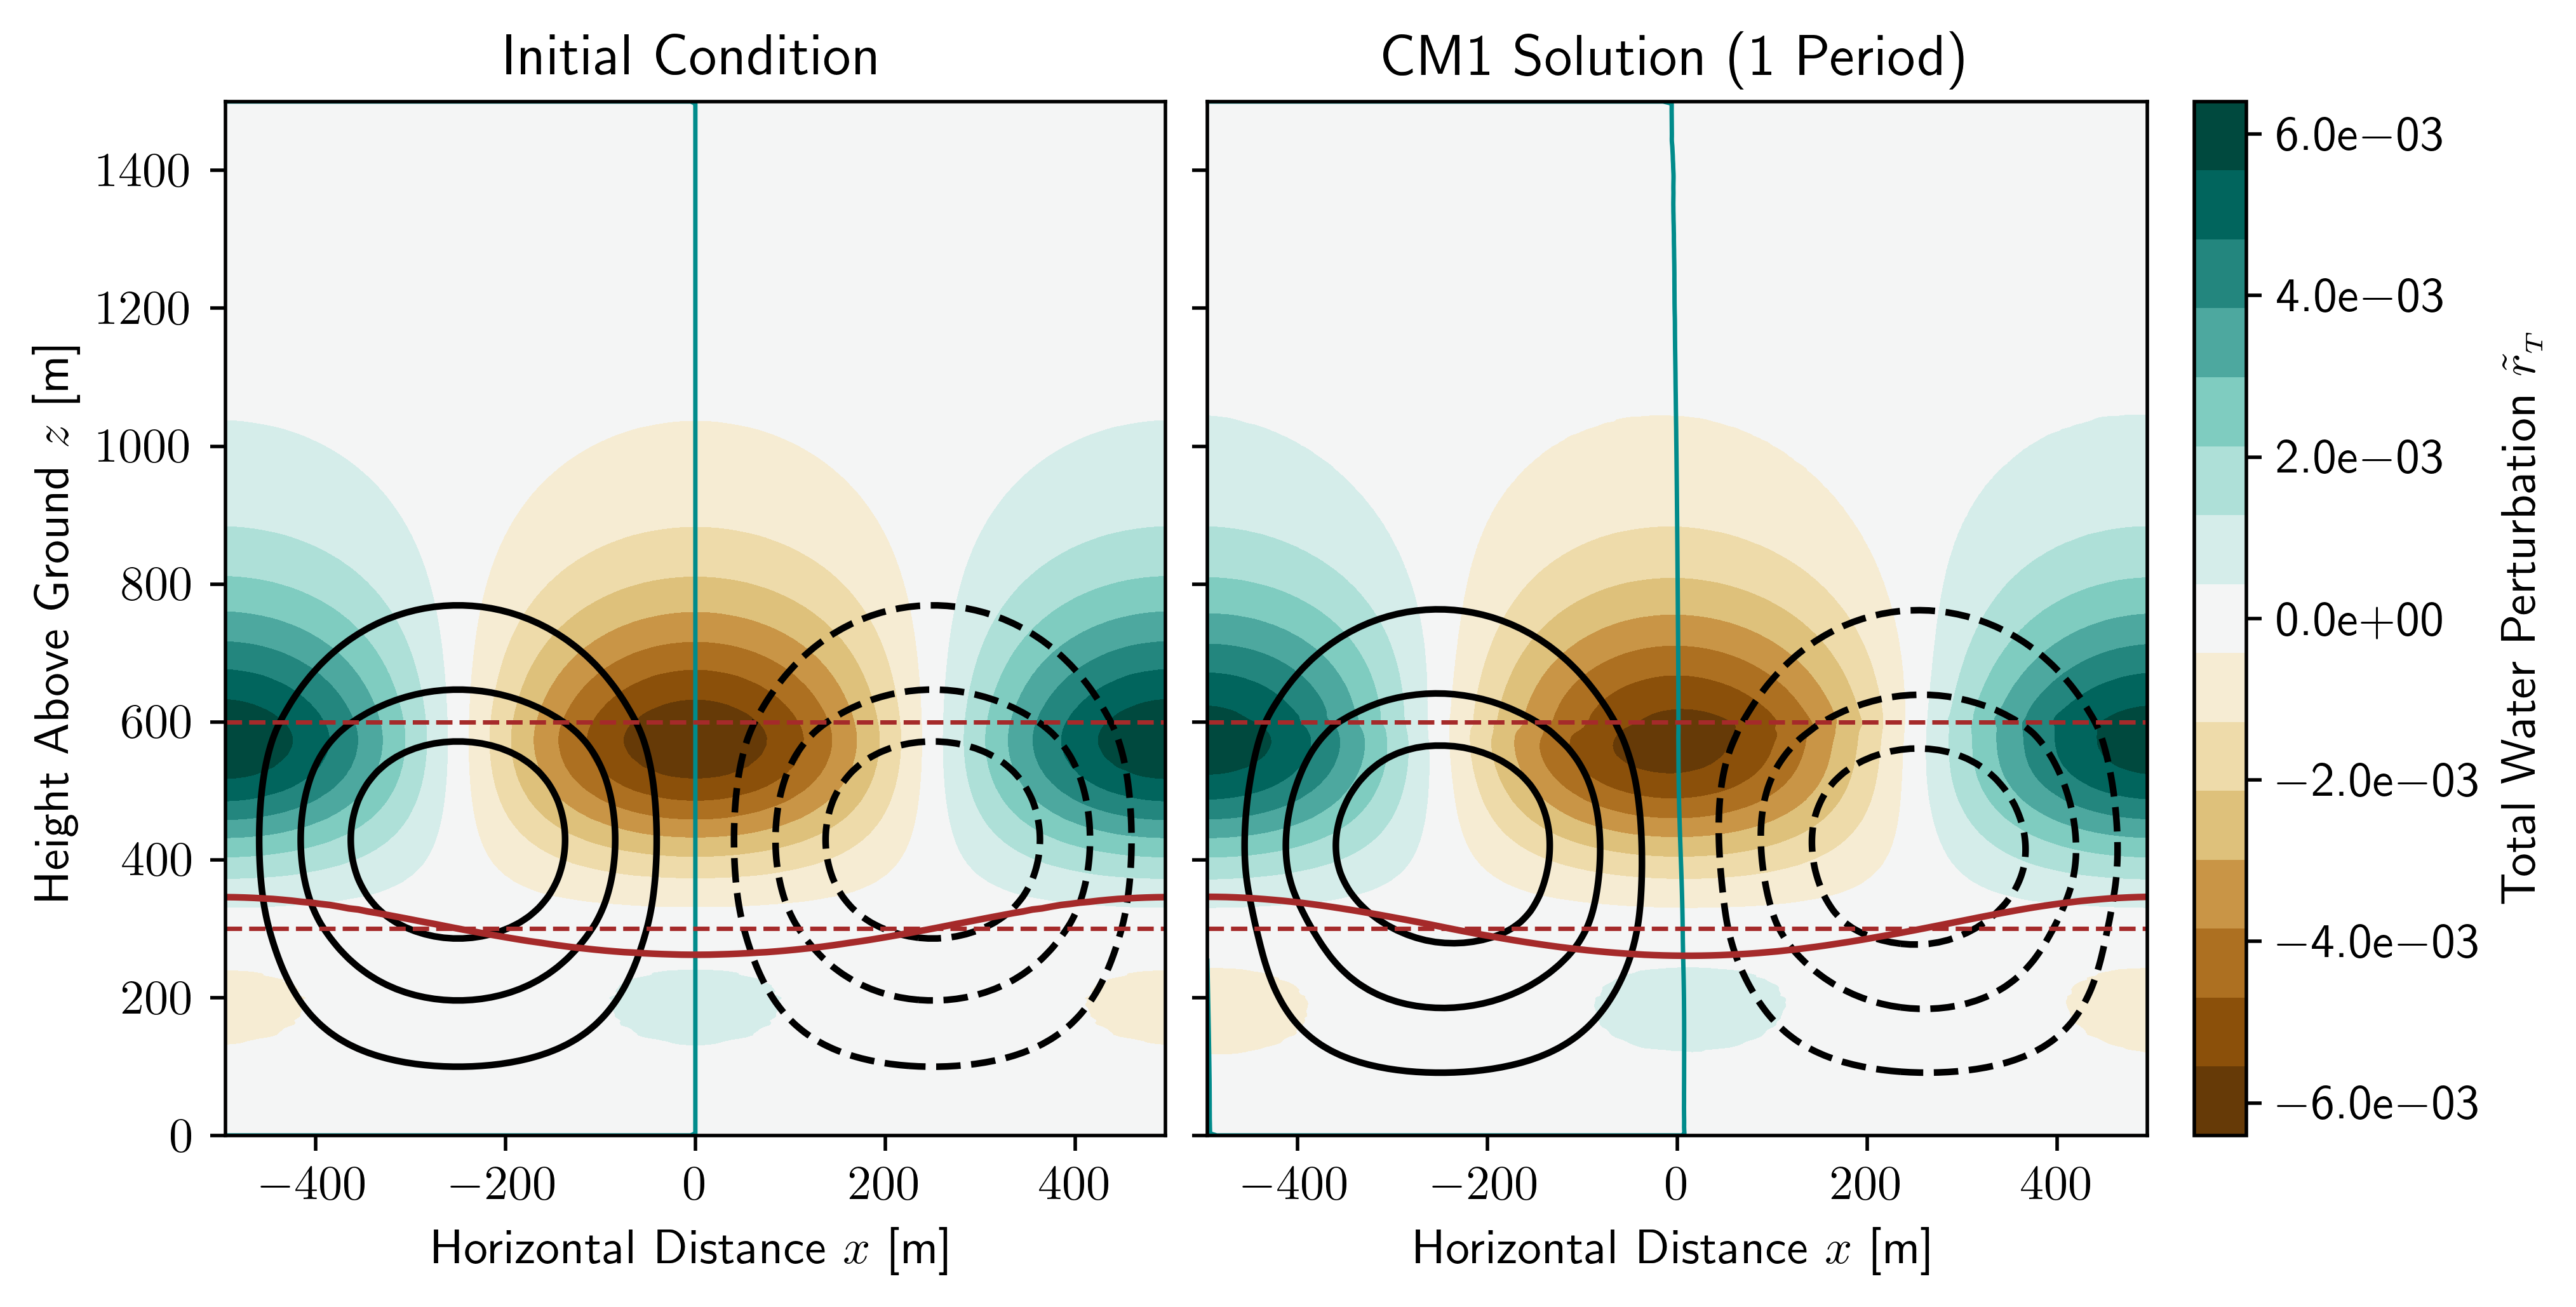

In [7]:
#rT perturbation (rT tilde really variable named for rT prime though...)
rTp = rT/rTbar[np.newaxis,:,np.newaxis] - 1

#plotting
fig, axes = plt.subplots(layout='constrained', ncols=2, sharey=True)
fig.set_dpi(500)
fig.set_size_inches(8,4)

rTmax = np.max(np.abs(rTp))
rTlevs = np.linspace(-rTmax, rTmax, 16)
axes[0].contourf(xh, zh, rTp[0,:,:], levels=rTlevs, cmap='BrBG')
cont = axes[1].contourf(xh, zh, rTp[-1,:,:], levels=rTlevs, cmap='BrBG')
cb = fig.colorbar(cont, label=r'Total Water Perturbation $\tilde{r}_{\scriptscriptstyle{T}}$', format='{x:.1e}',
                  ticks=np.arange(-6e-3, 7e-3, 2e-3))

wmax = np.max(np.abs(w))
axes[0].contour(xh, zf, w[0,:,:], levels=[0], colors='darkcyan', linewidths=1)
axes[0].contour(xh, zf, w[0,:,:], levels=np.linspace(0,wmax,5)[1:], colors='k')
axes[0].contour(xh, zf, w[0,:,:], levels=np.linspace(-wmax,0,4,endpoint=False), colors='k')

axes[1].contour(xh, zf, w[-1,:,:], levels=[0], colors='darkcyan', linewidths=1)
axes[1].contour(xh, zf, w[-1,:,:], levels=np.linspace(0,wmax,5)[1:], colors='k')
axes[1].contour(xh, zf, w[-1,:,:], levels=np.linspace(-wmax,0,4,endpoint=False), colors='k')

axes[0].plot(xh, Zcm1[0,:], color='brown')

axes[1].plot(xh, Zcm1[-1,:], color='brown')

axes[0].set(xlabel=r'Horizontal Distance $x$ [m]', ylabel=r'Height Above Ground $z$ [m]', 
            title='Initial Condition')
axes[1].set(xlabel=r'Horizontal Distance $x$ [m]', title='CM1 Solution (1 Period)')

axes[0].axhline(600, linestyle='dashed', color='brown', linewidth=1)
axes[0].axhline(300, linestyle='dashed', color='brown', linewidth=1)
axes[1].axhline(600, linestyle='dashed', color='brown', linewidth=1)
axes[1].axhline(300, linestyle='dashed', color='brown', linewidth=1)

plt.show()

Presentation version (save figures for each frame to use in animation)

In [8]:
#Make directory to save figures
os.makedirs('wave-frames', exist_ok=True)

#Again theta_l and rT tilde really not prime
thlp = thl/thlbar[np.newaxis,:,np.newaxis] - 1
rTp = rT/rTbar[np.newaxis,:,np.newaxis] - 1

#loop through the time dimension + 16 repeat frames to make the "pause" before the animation loops
for frame in range(p.shape[0]+16):
    if frame >= p.shape[0]: idt = p.shape[0]-1
    else: idt = frame
    fig, axes = plt.subplots(layout='constrained', ncols=2, sharey=True)
    fig.set_dpi(500)
    fig.set_size_inches(8,4)

    axes[0].set_title(r'LW Potential Temperature Disturbance $\tilde{\theta}_{\scriptscriptstyle{\ell}}$')

    thlmax = np.max(np.abs(thlp))
    thllevs = np.linspace(-thlmax, thlmax, 16)
    contthl = axes[0].contourf(xh, zh, thlp[idt,:,:], levels=thllevs, cmap='PRGn_r')
    cbthl = fig.colorbar(contthl, 
                        format='{x:.1e}',
                        ticks=np.arange(-4e-4, 5e-4, 4e-4),
                        orientation='horizontal')
    cbthl.ax.set_xticklabels([r'$-4\times10^{-4}$', r'$0$', r'$4\times10^{-4}$'])

    axes[1].set_title(r'Total Water Perturbation $\tilde{r}_{\scriptscriptstyle{T}}$')

    rTmax = np.max(np.abs(rTp))
    rTlevs = np.linspace(-rTmax, rTmax, 16)
    contrT = axes[1].contourf(xh, zh, rTp[idt,:,:], levels=rTlevs, cmap='BrBG')
    cbrT = fig.colorbar(contrT, 
                        format='{x:.1e}',
                        ticks=np.arange(-5e-3, 7e-3, 5e-3),
                        orientation='horizontal')
    
    cbrT.ax.set_xticklabels([r'$-5\times10^{-4}$', r'$0$', r'$5\times10^{-4}$'])


    wmax = np.max(np.abs(w))
    axes[0].contour(xh, zf, w[idt,:,:], levels=[0], colors='darkcyan', linewidths=1)
    axes[0].contour(xh, zf, w[idt,:,:], levels=np.linspace(0,wmax,5)[1:], colors='k')
    axes[0].contour(xh, zf, w[idt,:,:], levels=np.linspace(-wmax,0,4,endpoint=False), colors='k')

    axes[1].contour(xh, zf, w[idt,:,:], levels=[0], colors='darkcyan', linewidths=1)
    axes[1].contour(xh, zf, w[idt,:,:], levels=np.linspace(0,wmax,5)[1:], colors='k')
    axes[1].contour(xh, zf, w[idt,:,:], levels=np.linspace(-wmax,0,4,endpoint=False), colors='k')

    axes[0].plot(xh, Zcm1[idt,:], color='brown')
    axes[1].plot(xh, Zcm1[idt,:], color='brown')
    ql_mask = np.where(rl[idt,:] > 0, 1, np.nan)
    axes[0].contourf(xh, zh, ql_mask, cmap='gray', alpha=0.4)
    axes[1].contourf(xh, zh, ql_mask, cmap='gray', alpha=0.4)


    axes[0].set(xlabel=r'Horizontal Distance $x$ [m]', ylabel=r'Height Above Ground $z$ [m]')
    axes[1].set(xlabel=r'Horizontal Distance $x$ [m]')
    
    axes[0].axhline(600, linestyle='dashed', color='brown', linewidth=1)
    axes[0].axhline(300, linestyle='dashed', color='brown', linewidth=1)

    axes[1].axhline(600, linestyle='dashed', color='brown', linewidth=1)
    axes[1].axhline(300, linestyle='dashed', color='brown', linewidth=1)

    plt.savefig(f'./wave-frames/frame-{frame}.png', dpi=250)   
    plt.close()